In [50]:
import numpy as np
import pandas as pd


n = 50
d = 3

x = np.random.uniform(-1, 1, (n, d))
print("input data shape:")
print(x.shape)

#y1 = x1^2 + 2*x2 + x3
#y2 = x1^3 + 2*x2^2 + 5*x3
def f(x):
  y1 =  (x[:,0]*x[:,0]) + (2*x[:,1]) + x[:,2]
  y2 = (x[:,0]*x[:,0]*x[:,0]) + (2*x[:,1]*x[:,1]) + (5*x[:,2])
  return np.vstack((y1,y2)).T

y_true = f(x)

print("Output data shape:")
print(y_true.shape)

input data shape:
(50, 3)
Output data shape:
(50, 2)


# **Model training using keras fit function**

In [51]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

inputs = keras.Input(shape=(3,))
l1 = layers.Dense(10, activation='relu', name='layer1')(inputs)
l2 = layers.Dense(10, activation='relu', name='layer2')(l1)
outputs = layers.Dense(2, name='output')(l2)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

model.compile(loss='mse', optimizer = optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 10)                40        
_________________________________________________________________
layer2 (Dense)               (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2/2 [==============================] - 0s 4ms/step - loss: 6.2498
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 4.5733
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 3.6746
Epoch 4/10
2/2 [=======

# **Model training using custom fit function and custom MLP model class**

In [52]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras

class CustomLinearLayer(keras.layers.Layer):
  def __init__(self, units=32):
      super(CustomLinearLayer, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b


  


In [84]:
class CustomMLP(keras.layers.Layer):
  def __init__(self, output_dim):
      super(CustomMLP, self).__init__()
      self.dense_1 = layers.Dense(50, activation=tf.nn.relu)
      self.dense_2 = layers.Dense(32, activation=tf.nn.relu)
      self.dense_3 = layers.Dense(output_dim)

  def forward(self, inputs):
      x = self.dense_1(inputs)
      x = self.dense_2(x)
      return self.dense_3(x)

  def fit(self, input, y_true, epoch):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
    for step in range(epoch):
      with tf.GradientTape() as tape:
        y_pred = self.forward(input)
        loss = tf.keras.losses.MSE(y_true, y_pred)
        loss += sum(mlp.losses)
        loss =  tf.math.reduce_sum(loss) / float(tf.size(loss))
        gradients = tape.gradient(loss, self.dense_1.trainable_weights + self.dense_2.trainable_weights + self.dense_3.trainable_weights)
      optimizer.apply_gradients(zip(gradients, self.dense_1.trainable_weights + self.dense_2.trainable_weights + self.dense_3.trainable_weights))
      print('Step:', step, 'Loss:', loss)

    return y_pred

In [85]:
mlp = CustomMLP(2)
y_pred = mlp.fit(x, y_true, 10)


Step: 0 Loss: tf.Tensor(6.0753675, shape=(), dtype=float32)
Step: 1 Loss: tf.Tensor(5.3141303, shape=(), dtype=float32)
Step: 2 Loss: tf.Tensor(4.80078, shape=(), dtype=float32)
Step: 3 Loss: tf.Tensor(4.2974176, shape=(), dtype=float32)
Step: 4 Loss: tf.Tensor(3.7457426, shape=(), dtype=float32)
Step: 5 Loss: tf.Tensor(3.1163, shape=(), dtype=float32)
Step: 6 Loss: tf.Tensor(2.4260345, shape=(), dtype=float32)
Step: 7 Loss: tf.Tensor(1.7939699, shape=(), dtype=float32)
Step: 8 Loss: tf.Tensor(1.2740933, shape=(), dtype=float32)
Step: 9 Loss: tf.Tensor(0.89112055, shape=(), dtype=float32)


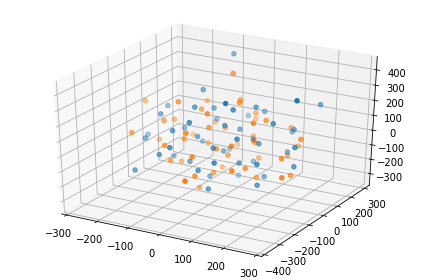

In [86]:
def Display3D(ax, x, output):
  from sklearn.manifold import TSNE
  df_true = pd.concat([pd.DataFrame(x),pd.DataFrame(output)], axis=1)
  perplexity = 50
  tsne_3d = TSNE(n_components=3, perplexity=perplexity)
  TCs_3d = pd.DataFrame(tsne_3d.fit_transform(df_true))
  TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]
  ax.scatter3D(TCs_3d['TC1_3d'], TCs_3d['TC2_3d'], TCs_3d['TC3_3d'])

def DisplayPlotAndLoss(x, y_true, y_pred):
  
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  Display3D(ax, x, y_true)
  Display3D(ax, x, y_pred)
  plt.tight_layout()
  plt.show()

DisplayPlotAndLoss(x, y_true, y_pred)